In [43]:
import pandas as pd
import numpy as np
import os
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [45]:
# Giving access to the path to read the features.txt file and printing them
Load_features = "./UCI HAR Dataset/features.txt"

with open(Load_features, "r") as f:
    features_name = f.readlines()
UCI_Features = [line.strip() for line in features_name if line.strip()]
Features_display = pd.DataFrame(UCI_Features[:20], columns=["Features of UCI HAR Dataset"])
Style_Features_display = Features_display.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)
display(Style_Features_display)

STEP 1. LOADING THE TEST AND TRAIN DATASET TO COMBINE BOTH INTO ONE CSV.
HERE ASSIGNING COLUMN NAME: ASSIGNED USERS AND WHICH ACTIVITIES THEY HAVE PERFORMED TO PLOT THE GRAPH IN THE BELOW STEPS.

In [46]:
# Subject columns consist of the users details, hence, reading those information.

UCI_Subject_Train = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None, names=['User'])
UCI_Subject_Test = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None, names=['User'])
UCI_X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
UCI_X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)
UCI_y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, names=['Activity'])
UCI_y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, names=['Activity'])
UCI_X_train.columns = UCI_Features
UCI_X_test.columns = UCI_Features

# Loading activity information.
UCI_Activity_Information = pd.read_csv('UCI HAR Dataset/activityinformation.txt', delim_whitespace=True, header=None, names=['ActivityID', 'ActivityName'])
UCI_y_train['Activity'] = UCI_y_train['Activity'].map(UCI_Activity_Information.set_index('ActivityID')['ActivityName'].to_dict())
UCI_y_test['Activity'] = UCI_y_test['Activity'].map(UCI_Activity_Information.set_index('ActivityID')['ActivityName'].to_dict())

train_data = pd.concat([UCI_Subject_Train, UCI_y_train, UCI_X_train], axis=1)
test_data = pd.concat([UCI_Subject_Test, UCI_y_test, UCI_X_test], axis=1)

STEP. 02. IMPLEMENTING CHECKPOINTS AND SAVING THE FILES TO TRAIN THE MODEL ON RAW DATASET AND WILL USE THE SAME FOR TRADITIONAL AND ADVANCE TECHNIQUES.

In [47]:
# Combine train and test data into one DataFrame
UCI_Merged_Data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)
print('Number of UCI Merged duplicated data = {}'.format(sum(UCI_Merged_Data.duplicated())))
print('Number of UCI Merged Null Values = {}'.format(UCI_Merged_Data.isnull().values.sum()))

if not os.path.exists('./UCI HAR Dataset/Data'):
    os.makedirs('./UCI HAR Dataset/Data')

UCI_Merged_Data.to_csv('./UCI HAR Dataset/Data/BaseFiles/UCI_Cleaned_Dataset.csv', index=False, float_format='%.2f')
UCI_Cleaned_Dataset = pd.read_csv('./UCI HAR Dataset/Data/BaseFiles/UCI_Cleaned_Dataset.csv')
print("Number of UCI Cleaned Dataset Rows and Columns:", UCI_Cleaned_Dataset.shape) 

# Get 20 random samples from the data
UCI_Cleaned_Dataset_Random_Sample = UCI_Cleaned_Dataset.sample(n=20, random_state=42)
UCI_Cleaned_Dataset_Random_Sample_Display = UCI_Cleaned_Dataset_Random_Sample.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
).format(precision=2)

display(UCI_Cleaned_Dataset_Random_Sample_Display)



Number of UCI Merged duplicated data = 0
Number of UCI Merged Null Values = 0
Number of UCI Cleaned Dataset Rows and Columns: (10299, 563)


STEP. 3. A graph against headcounts and the activities performed by each user.

In [48]:
def plotGraphs(masterdataset,graph_name,title,x_label,y_label):
    
    match graph_name:
        case 'ACTIVITIES PERFORMED BY EACH USER':
           plt.figure(figsize=(14, 8))
           sns.countplot(masterdataset, x='User', hue='Activity')
           plt.title(title, fontsize=16)
           plt.legend(title='ACTIVITIES', bbox_to_anchor=(1.05, 1), loc='upper left')
        case 'EACH ACTIVITY DONE BY USERS':
            plt.figure(figsize=(10, 8))
            label_counts = masterdataset['Activity'].value_counts()
            palette = sns.color_palette("viridis", len(label_counts))
            sns.barplot(x=label_counts.index.str.capitalize(), y=label_counts.values, palette=palette)
            plt.title(title, fontsize=16)
        case 'FEATURE FOR STATIONARY VS MOVING ACTIVITY':
              plt.figure(figsize=(5, 5))
              sns.kdeplot(masterdataset, x= UCI_feature, hue='Activity', fill=True, common_norm=False, palette='muted')
              plt.title(f'Density Plot of {UCI_feature} for Stationary vs Moving Activities', fontsize=16)
              plt.legend(title='Activity Type')
              plt.tight_layout()
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

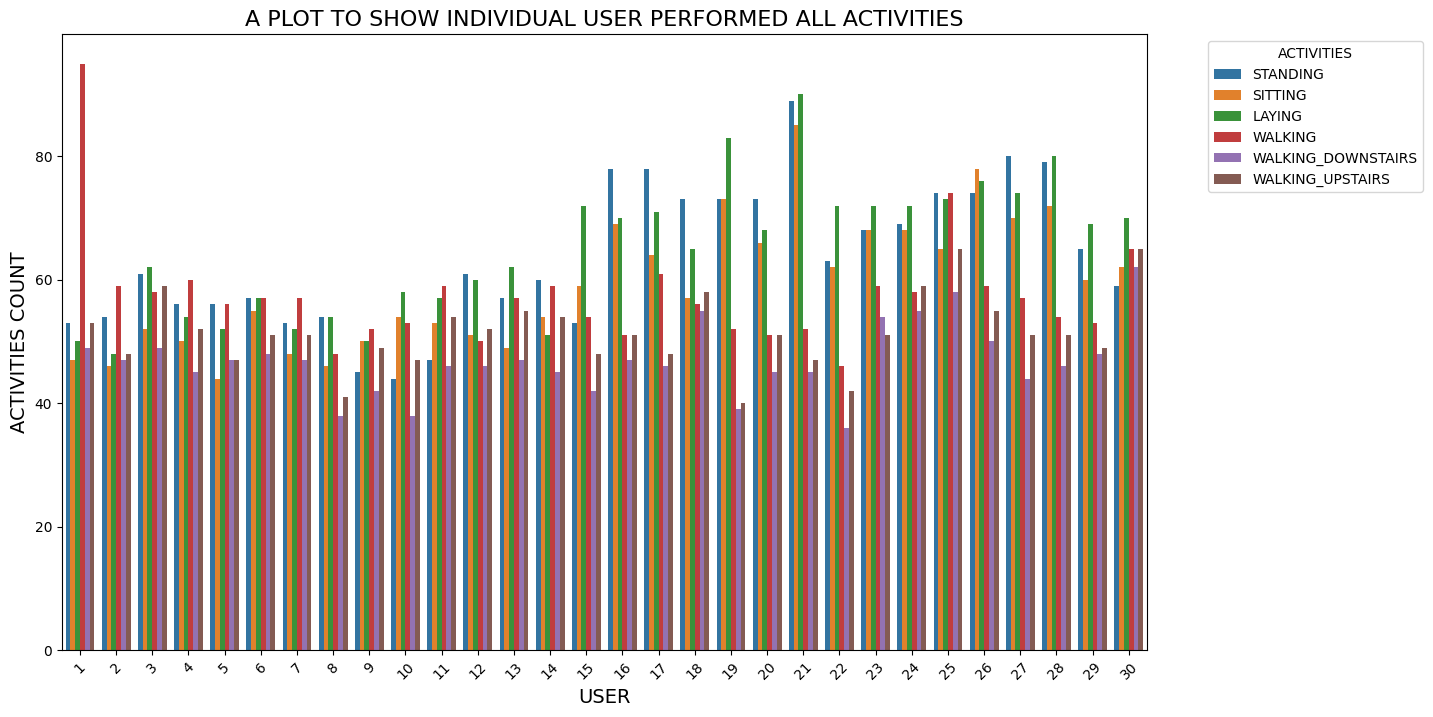

In [49]:
plotGraphs(UCI_Cleaned_Dataset,'ACTIVITIES PERFORMED BY EACH USER','A PLOT TO SHOW INDIVIDUAL USER PERFORMED ALL ACTIVITIES','USER','ACTIVITIES COUNT')

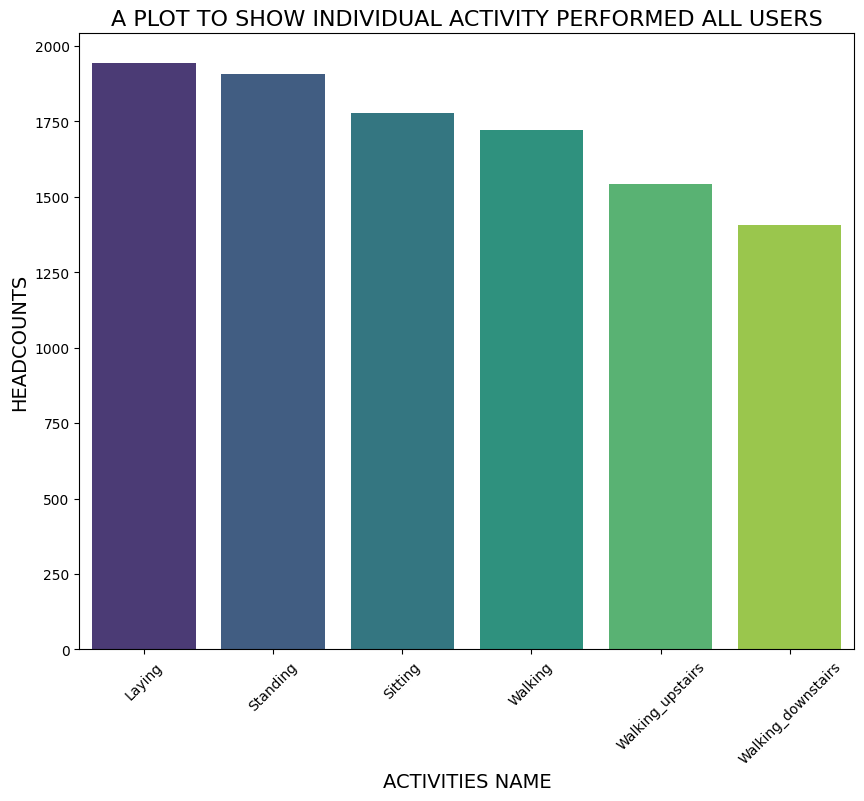

In [50]:
plotGraphs(UCI_Cleaned_Dataset,'EACH ACTIVITY DONE BY USERS','A PLOT TO SHOW INDIVIDUAL ACTIVITY PERFORMED ALL USERS','ACTIVITIES NAME','HEADCOUNTS')

STEP. 4. Plotting a pie chart for moving and stationary activities.

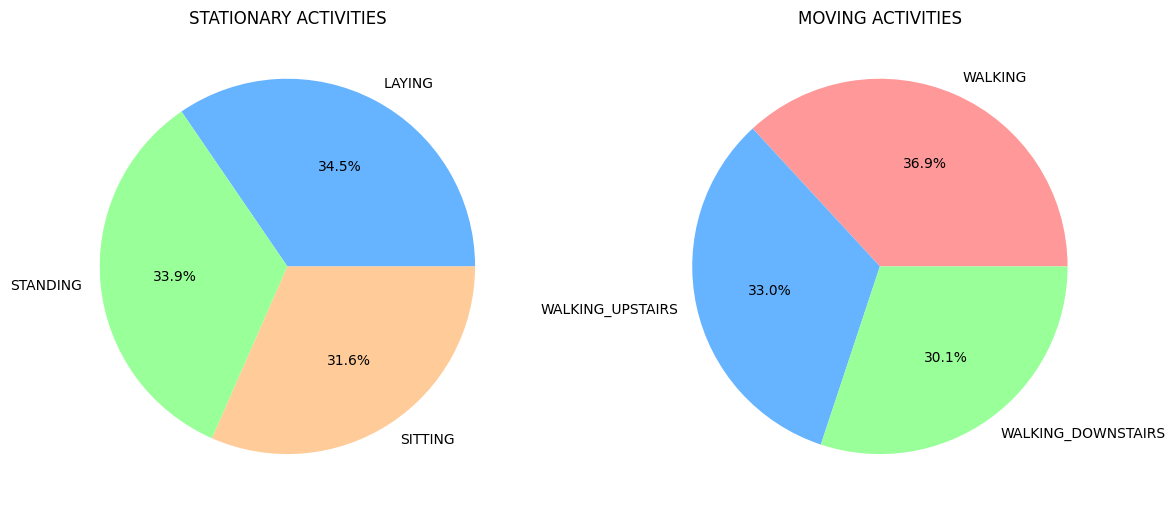

In [51]:
# Assigning moving and stationary task

UCI_Stationary_Activities = ['STANDING', 'SITTING', 'LAYING']
UCI_Moving_Activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
UCI_Cleaned_Dataset['ActivityCategory'] = UCI_Cleaned_Dataset['Activity'].apply(
    lambda x: 'Stationary' if x.upper() in UCI_Stationary_Activities else 'Moving'
)
UCI_Stationary_Activities_Counts = UCI_Cleaned_Dataset[UCI_Cleaned_Dataset['ActivityCategory'] == 'Stationary']['Activity'].value_counts()
UCI_Moving_Activities_Counts = UCI_Cleaned_Dataset[UCI_Cleaned_Dataset['ActivityCategory'] == 'Moving']['Activity'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Stationary_activities_graph
axs[0].pie(
    UCI_Stationary_Activities_Counts,
    labels=UCI_Stationary_Activities_Counts.index,
    autopct='%1.1f%%',
    colors=['#66b3ff', '#99ff99', '#ffcc99']
)
axs[0].set_title('STATIONARY ACTIVITIES')

# Moving_activities_graph
axs[1].pie(
    UCI_Moving_Activities_Counts,
    labels=UCI_Moving_Activities_Counts.index,
    autopct='%1.1f%%',
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
axs[1].set_title('MOVING ACTIVITIES')

# Plot the graphs
plt.tight_layout()
plt.show()

STEP. 4.2. Plotting some features density graph for moving and stationary activities.

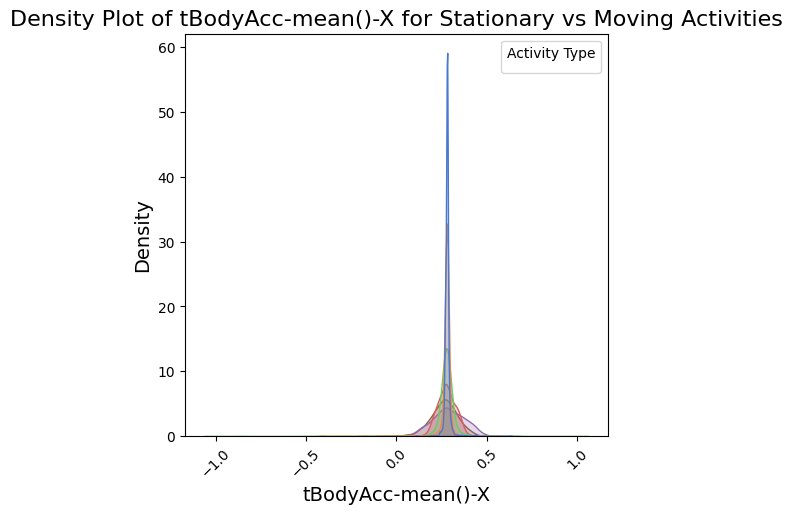

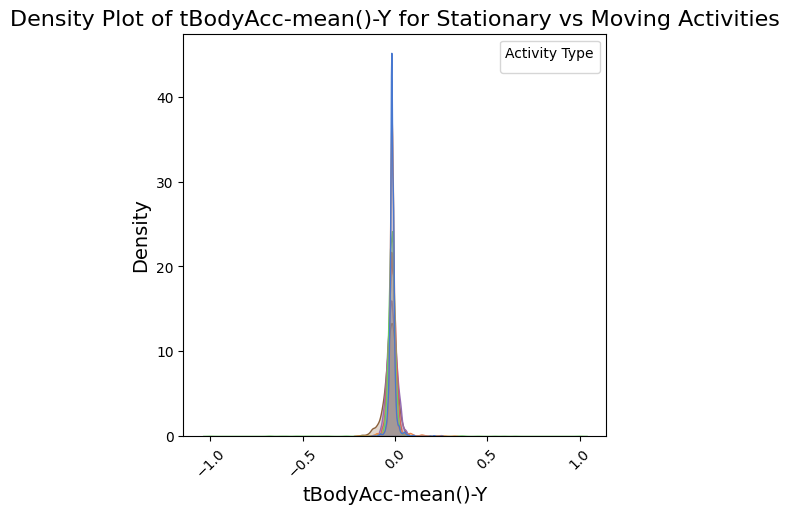

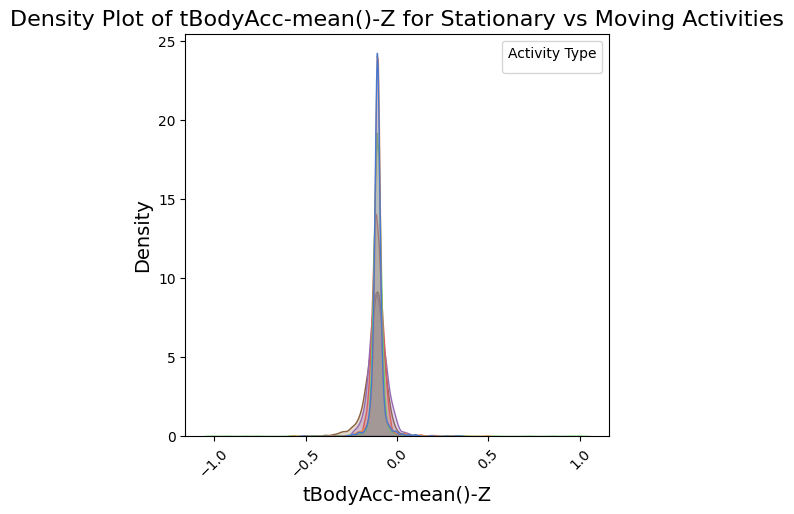

In [52]:
UCI_Selected_Features = ['tBodyAcc-mean()-X' ,'tBodyAcc-mean()-Y' ,'tBodyAcc-mean()-Z'] #Graphs to show features maps between stationary vs moving activities for any 3 feature.
for UCI_feature in UCI_Selected_Features:
    plotGraphs(UCI_Cleaned_Dataset,'FEATURE FOR STATIONARY VS MOVING ACTIVITY',f'Density Plot of {UCI_feature} for Stationary vs Moving Activities',UCI_feature,'Density')

STEP. 5 Descriptive Statistics

In [53]:
# Firstly, remove the columns who contain string value.

UCI_Numeric_Columns = UCI_Cleaned_Dataset.select_dtypes(include=['float64', 'int64']).columns
UCI_Interger_Value = UCI_Cleaned_Dataset[UCI_Numeric_Columns]

# Descriptive staticial analysis
UCI_Data_Stats_Analysis = UCI_Interger_Value.describe().T

# Additional statistics: Variance, Skewness, and Kurtosis
variance = UCI_Interger_Value.var()
skewness = UCI_Interger_Value.skew()
kurtosis = UCI_Interger_Value.kurt()

# Combine all statistics into one DataFrame
UCI_Data_Stats_Analysis_Data_Frame = pd.DataFrame({
    'MEAN': UCI_Data_Stats_Analysis['mean'],
    'STD': UCI_Data_Stats_Analysis['std'],
    'MIN': UCI_Data_Stats_Analysis['min'],
    '25%': UCI_Data_Stats_Analysis['25%'],
    '50%': UCI_Data_Stats_Analysis['50%'],
    '75%': UCI_Data_Stats_Analysis['75%'],
    'MAX': UCI_Data_Stats_Analysis['max'],
    'VARIANCE': variance,
    'SKEWNESS': skewness,
    'KURTOSIS': kurtosis
})

# Formatting to get the sample result in table format
UCI_Data_Stats_Analysis_Display = UCI_Data_Stats_Analysis_Data_Frame.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
).format(precision=2)

display(UCI_Data_Stats_Analysis_Display)

STEP. 5.2. Correlation Analysis

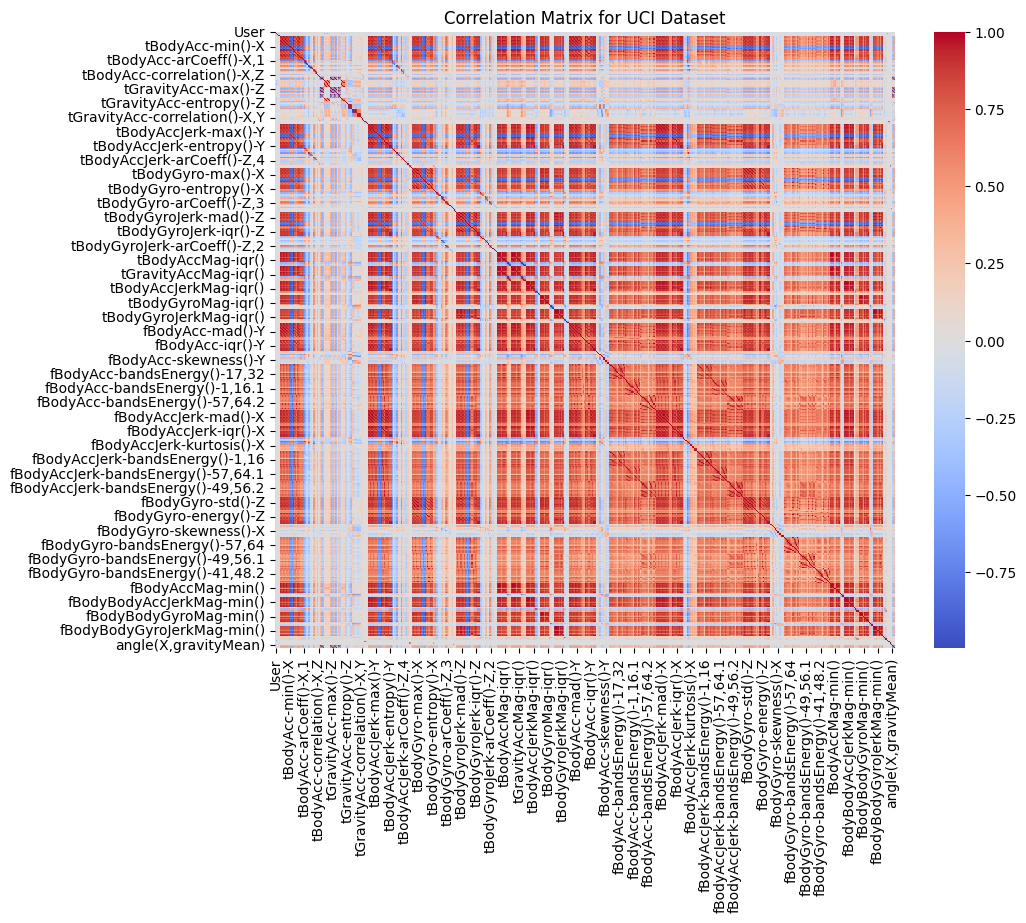

In [54]:
# Evaluate the confusion matrix for integers
UCI_Correlation_Matrix = UCI_Interger_Value.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(UCI_Correlation_Matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix for UCI Dataset')
plt.show()

STEP. 5 3. Distribution Analysis

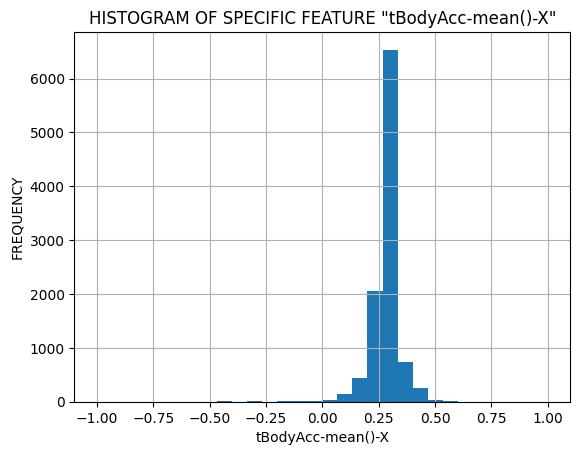

In [55]:
# Considering 'tBodyAcc-mean()-X' to plot histogram for a specific feature
UCI_Cleaned_Dataset['tBodyAcc-mean()-X'].hist(bins=30)
plt.title('HISTOGRAM OF SPECIFIC FEATURE "tBodyAcc-mean()-X"')
plt.xlabel('tBodyAcc-mean()-X')
plt.ylabel('FREQUENCY')
plt.show()

STEP. 5.4. Outlier Detection

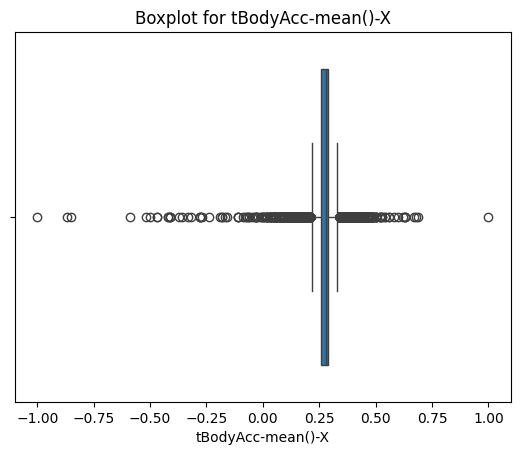

In [56]:
# Boxplot for a specific feature to detect outliers
sns.boxplot(x=UCI_Cleaned_Dataset['tBodyAcc-mean()-X'])
plt.title('Boxplot for tBodyAcc-mean()-X')
plt.show()

STEP. 06. TRAINING THE MODELS

FOR THIS PROJECT I AM SELECTING FOUR BEST SUITED MODELS FOR DATA AUGMNETATION TECHNIQUES STUDY.

01. RANDOM FOREST
02. SUPPORT VECTOR MACHINE (SVM)
03. CONVOLUTIONAL NEURAL NETWORK (CNN)
04. LONG SHORT-TERM MEMORY (LSTM)

In [57]:
# Spliting feature and labels

UCI_X_Data = UCI_Cleaned_Dataset.drop(columns=['Activity'])
UCI_Y_Data = UCI_Cleaned_Dataset['Activity']

# Implementing Encoder, as it might be required for some model
UCI_Label_Encoder = LabelEncoder()
UCI_Y_Encoded = UCI_Label_Encoder.fit_transform(UCI_Y_Data)

# Spliting the dataset into 80% train and 20% test data
UCI_Cleaned_X_Train, UCI_Cleaned_X_Test, UCI_Cleaned_Y_Train, UCI_Cleaned_Y_Test = train_test_split(UCI_X_Data, UCI_Y_Encoded, test_size=0.2, random_state=42)

UCI_Label_Encoder = {}
for column in UCI_Cleaned_X_Train.columns:
    if UCI_Cleaned_X_Train[column].dtype == 'object':  # Check if the column is categorical
        le = LabelEncoder()
        UCI_Cleaned_X_Train[column] = le.fit_transform(UCI_Cleaned_X_Train[column])
        UCI_Cleaned_X_Test[column] = le.transform(UCI_Cleaned_X_Test[column])
        UCI_Label_Encoder[column] = le 

In [58]:
def trainAndtestdatasheet(modelsName, UCI_Cleaned_X_Train, UCI_Cleaned_X_Test):
    if modelsName == 'LSTM':
        UCI_X_Train = np.expand_dims(UCI_Cleaned_X_Train, axis=1)
        UCI_X_Test = np.expand_dims(UCI_Cleaned_X_Test, axis=1)
    else:
        UCI_X_Train = np.expand_dims(UCI_Cleaned_X_Train, axis=-1)
        UCI_X_Test = np.expand_dims(UCI_Cleaned_X_Test, axis=-1)

    return UCI_X_Train, UCI_X_Test


In [59]:
#Consolidating all results in single csv(accuracy,F1 Score)
def getAccuracyAndF1Score(Base,ModelName,Accuracy,F1Score):
    if not os.path.exists('./UCI HAR Dataset/results'):
        os.makedirs('./UCI HAR Dataset/results')

    result = {
        "Methodolgy":Base,
        "Model": ModelName,
        "Accuracy": Accuracy,
        "F1 Score": F1Score
    }
    file_path = './UCI HAR Dataset/results/results.csv'
    df_result = pd.DataFrame([result])
    if os.path.exists(file_path):
        df_result.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df_result.to_csv(file_path, mode='w', header=True, index=False)
        print(f"File {file_path} created and results logged.")

In [60]:

def TrainingModelAndGeneratingReport(TrainingModelName,ModelsName):
    ModelAccuracy = 0.0
    ModelClassificationDataFrame = pd.DataFrame
    UCI_X_Train, UCI_X_Test = trainAndtestdatasheet(ModelsName,UCI_Cleaned_X_Train, UCI_Cleaned_X_Test)
    if (ModelsName =='LSTM' or ModelsName =='CNN'):  
        TrainingModelName.fit(UCI_X_Train, UCI_Cleaned_Y_Train, epochs=3,batch_size=16,validation_data=(UCI_X_Test, UCI_Cleaned_Y_Test))
        UCI_Evaluation = TrainingModelName.evaluate(UCI_X_Test, UCI_Cleaned_Y_Test)
        ModelPrediction = np.argmax(TrainingModelName.predict(UCI_X_Test), axis=-1)
        ModelClassificationReport = classification_report(UCI_Cleaned_Y_Test, ModelPrediction, output_dict=True)
        ModelClassificationDataFrame = pd.DataFrame(ModelClassificationReport).transpose()
        ModelClassificationDataFrame.loc['accuracy'] = [UCI_Evaluation[1] * 100, '-', '-', '-']
        ModelAccuracy = accuracy_score(UCI_Cleaned_Y_Test, ModelPrediction) * 100
        ModelF1Score = f1_score(UCI_Cleaned_Y_Test, ModelPrediction, average='weighted')
    else:
        TrainingModelName.fit(UCI_Cleaned_X_Train, UCI_Cleaned_Y_Train)
        ModelPrediction = TrainingModelName.predict(UCI_Cleaned_X_Test)
        ModelAccuracy = accuracy_score(UCI_Cleaned_Y_Test, ModelPrediction) * 100
        ModelF1Score = f1_score(UCI_Cleaned_Y_Test, ModelPrediction, average='weighted')
        ModelClassificationReport = classification_report(UCI_Cleaned_Y_Test, ModelPrediction, output_dict=True)
        ModelClassificationDataFrame = pd.DataFrame(ModelClassificationReport).transpose()
        ModelClassificationDataFrame.loc['accuracy'] = [ModelAccuracy, '-', '-', '-']

    ModelClassificationDataFrame = ModelClassificationDataFrame.round(2)
    ModelClassificationDataFrame.columns = [col.upper() for col in ModelClassificationDataFrame.columns]
    ModelClassificationDataFrame.index = [idx.upper() for idx in ModelClassificationDataFrame.index]
    getAccuracyAndF1Score('Base Class',ModelsName,ModelAccuracy,ModelF1Score)
    #Displaying report
    Classification_Report_Display = ModelClassificationDataFrame.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
    ).format(precision=2)
    display(ModelsName+': Classification Report.')
    display(Classification_Report_Display)

    #Putting confusion matrix
    ModelConfusionmatrix= confusion_matrix(UCI_Cleaned_Y_Test, ModelPrediction)
    plt.figure(figsize=(10, 8))
    sns.heatmap(ModelConfusionmatrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(UCI_Cleaned_Y_Train), yticklabels=np.unique(UCI_Cleaned_Y_Train))
    plt.title(ModelsName + ' UCI : Confusion Matrix')
    plt.xlabel('PREDICTED LABEL')
    plt.ylabel('TRUE LABEL')
    plt.show()

In [61]:
def callModels(ModelsName):
    print("\033[1;34m.....................................................!\033[0m")
    print('Running for '+ModelsName+'.....................>>>>>')
    print("\033[1;34m.....................................................!\033[0m")
    UCI_X_Train, UCI_X_Test = trainAndtestdatasheet(ModelsName,UCI_Cleaned_X_Train, UCI_Cleaned_X_Test)
    match ModelsName.upper():
        case 'RANDOM FOREST':
            TrainingModelName = RandomForestClassifier(
            n_estimators=1,              # Fewer trees
            max_depth=4,                 # Limiting tree depth further
            max_features='sqrt',         # Reducing the number of features considered
            min_samples_split=10,        # Minimum samples required to split an internal node
            min_samples_leaf=5,          # Minimum samples required to be at a leaf node
            random_state=42
            )
           
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)
            
        case 'SVM':
            TrainingModelName = SVC(kernel='poly', degree=3, C=0.05, class_weight={0: 0.8, 1: 1.2})
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)
        case 'LSTM':
            TrainingModelName = models.Sequential([
            layers.LSTM(16, input_shape=(UCI_X_Train.shape[1], UCI_X_Train.shape[2])),  # Reduced LSTM units further
            layers.Dropout(0.6),  # More aggressive dropout
            layers.Dense(32, activation='relu'),  # Further reduced dense layer size
            layers.Dropout(0.6),  # Increased dropout in dense layer
            layers.Dense(len(np.unique(UCI_Cleaned_Y_Train)), activation='softmax')
])
            # Compile the model with a smaller learning rate
            TrainingModelName.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Very low learning rate
                                loss='sparse_categorical_crossentropy', 
                                metrics=['accuracy'])
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)

        case 'CNN': 
            TrainingModelName = models.Sequential([
            layers.Conv1D(8, kernel_size=3, activation='relu', input_shape=(UCI_X_Train.shape[1], 1)),  # Reduced filters
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.5),  # Higher dropout
            layers.Conv1D(16, kernel_size=3, activation='relu'),  # Reduced filters
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.5),  # Higher dropout
            layers.Flatten(),
            layers.Dense(32, activation='relu'),  # Smaller dense layer
            layers.Dropout(0.5),  # Adding dropout to dense layer
            layers.Dense(len(np.unique(UCI_Cleaned_Y_Train)), activation='softmax')  # Final layer
            ])
            # Compile with a smaller learning rate and Adam optimizer
            TrainingModelName.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Reduced learning rate
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
            # Early stopping based on validation accuracy
            #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)
            
    

........................TRAINING BASE WITH RAW DATA.............................!
.....................................................!
Running for RANDOM FOREST.....................>>>>>
.....................................................!
File ./UCI HAR Dataset/results/results.csv created and results logged.


'RANDOM FOREST: Classification Report.'

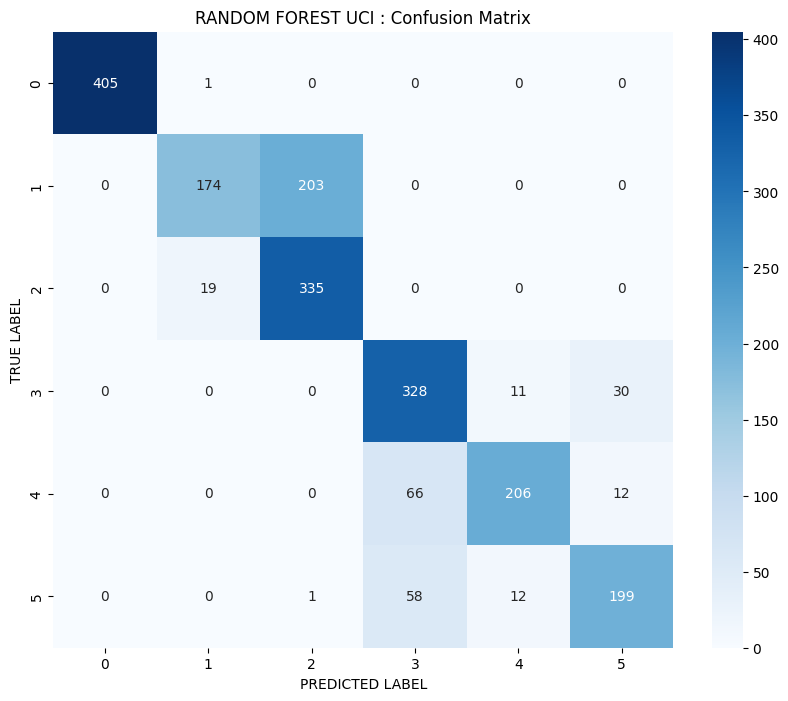

.....................................................!
Running for SVM.....................>>>>>
.....................................................!


'SVM: Classification Report.'

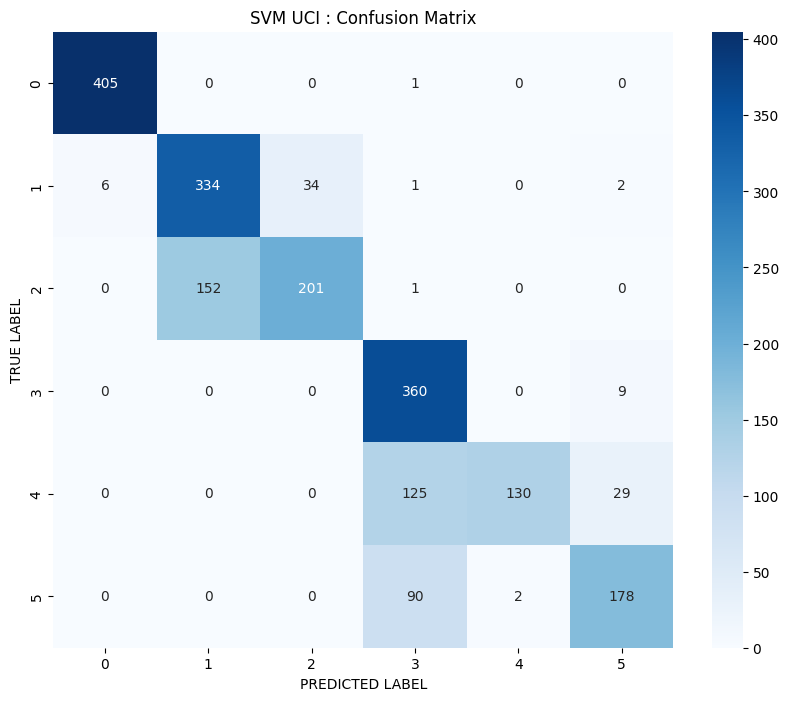

.....................................................!
Running for LSTM.....................>>>>>
.....................................................!
Epoch 1/3
515/515 [==============================] - 2s 2ms/step - loss: 1.7015 - accuracy: 0.2612 - val_loss: 1.4651 - val_accuracy: 0.5519
Epoch 2/3
515/515 [==============================] - 1s 1ms/step - loss: 1.4911 - accuracy: 0.3632 - val_loss: 1.1637 - val_accuracy: 0.6937
Epoch 3/3
65/65 [==============================] - 0s 563us/step


'LSTM: Classification Report.'

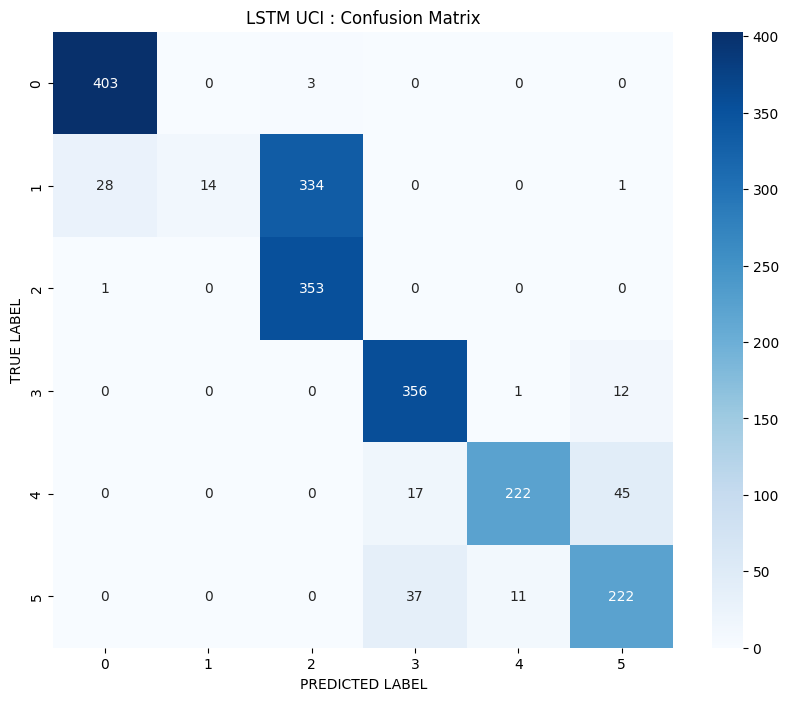

.....................................................!
Running for CNN.....................>>>>>
.....................................................!
Epoch 1/3
515/515 [==============================] - 2s 3ms/step - loss: 1.7072 - accuracy: 0.2554 - val_loss: 1.4050 - val_accuracy: 0.3282
Epoch 2/3
515/515 [==============================] - 2s 3ms/step - loss: 1.4083 - accuracy: 0.3630 - val_loss: 1.1501 - val_accuracy: 0.6262
Epoch 3/3
65/65 [==============================] - 0s 1ms/step


'CNN: Classification Report.'

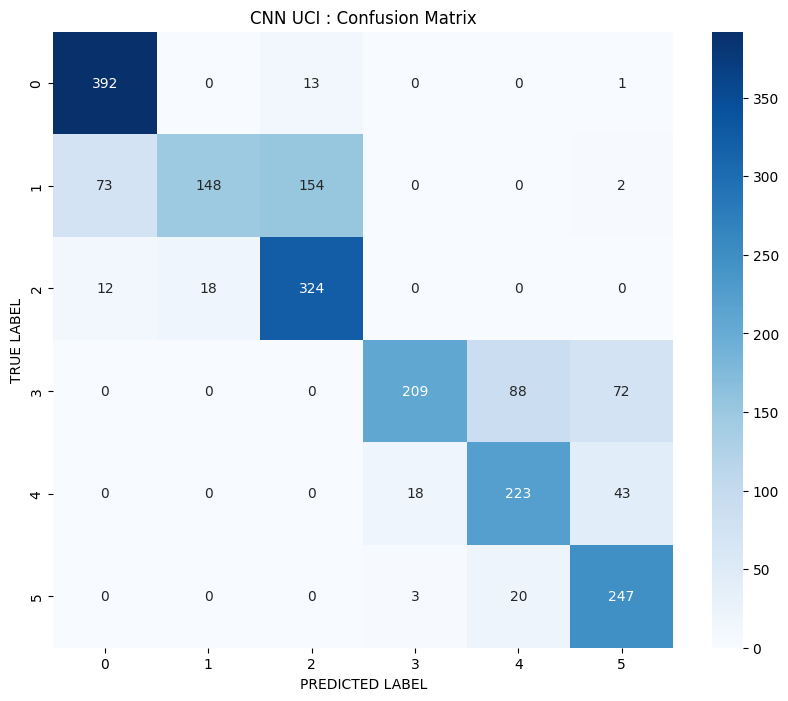

In [62]:
file_path = './UCI HAR Dataset/results/results.csv'
if os.path.exists(file_path):
   os.remove(file_path)
print("\033[1;32m........................TRAINING BASE WITH RAW DATA.............................!\033[0m")
callModels('RANDOM FOREST')
callModels('SVM')
callModels('LSTM')
callModels('CNN')

(72093, 563)
Number of duplicates in the augmented dataset: 13411
Number of null values in the augmented dataset: 0
Duplicates or null values found.
Shape after removing duplicates: (58682, 563)


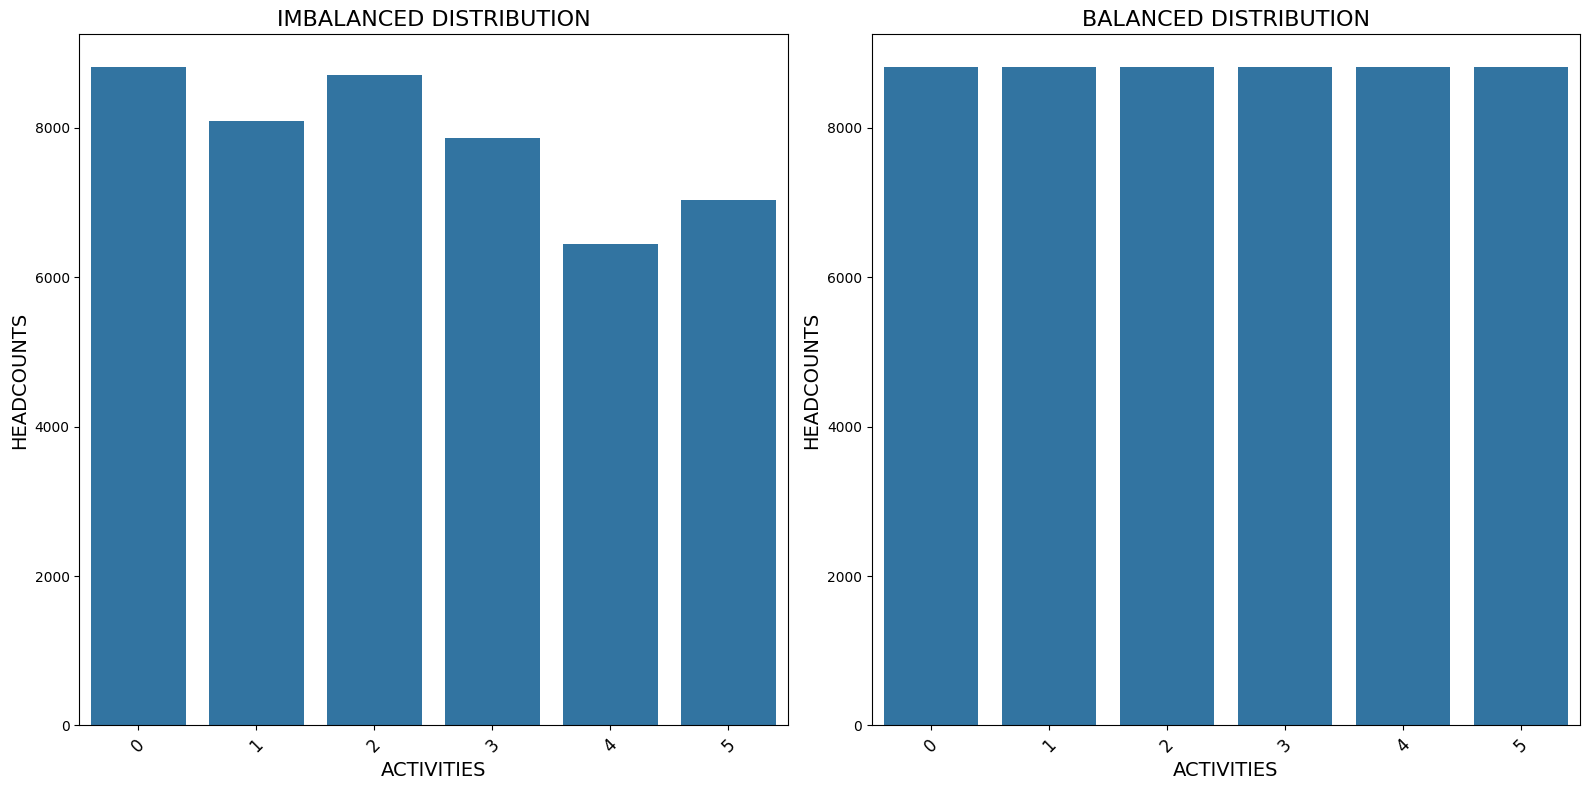

.........................TRAINING TRADITIONAL............................!
.....................................................!
Running for Traditional RANDOM FOREST.....................>>>>>
.....................................................!


'RANDOM FOREST: Classification Report.'

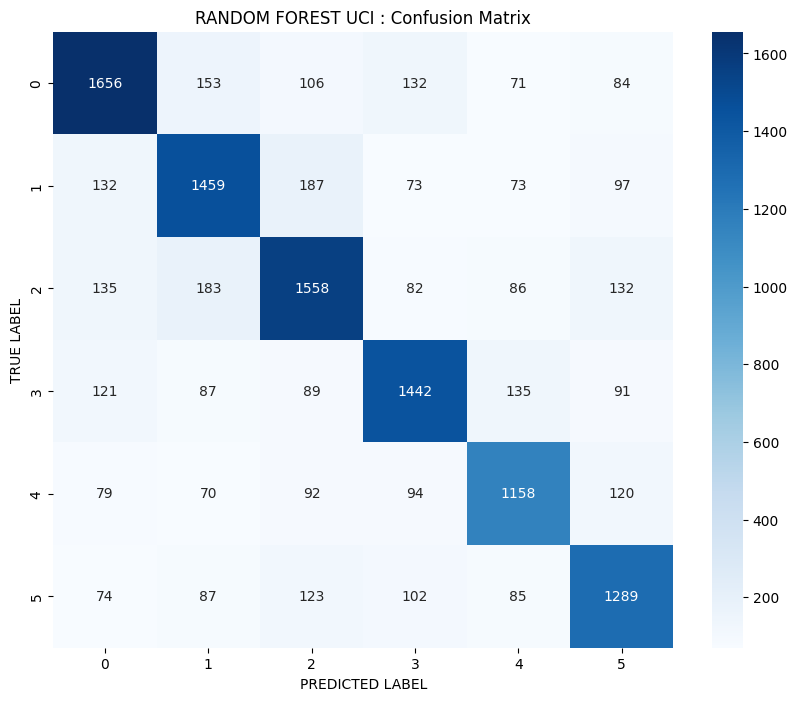

.....................................................!
Running for Traditional SVM.....................>>>>>
.....................................................!


'SVM: Classification Report.'

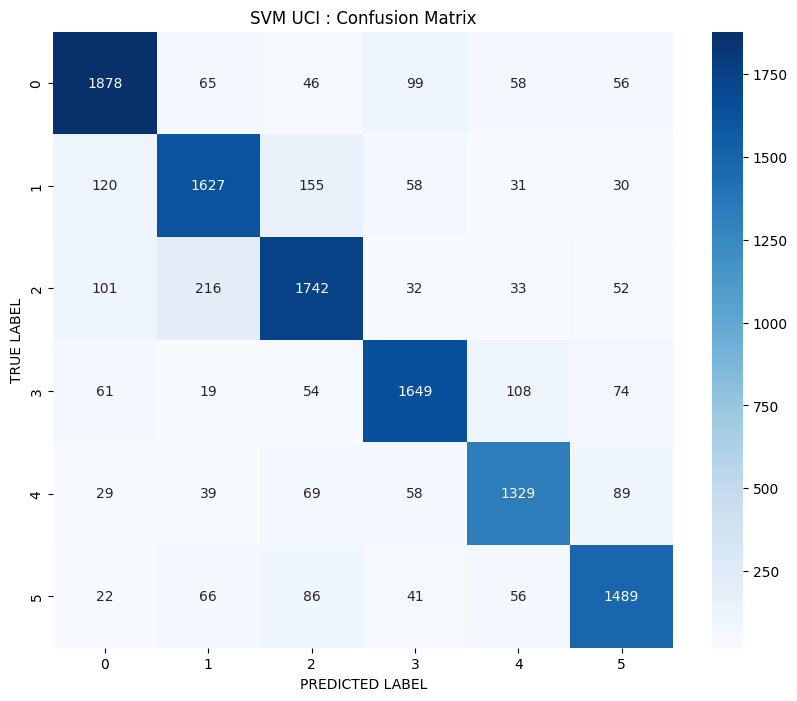

.....................................................!
Running for Traditional LSTM.....................>>>>>
.....................................................!
Epoch 1/10
1652/1652 [==============================] - 5s 2ms/step - loss: 0.7553 - accuracy: 0.7954 - val_loss: 0.6916 - val_accuracy: 0.8242
Epoch 2/10
1652/1652 [==============================] - 4s 2ms/step - loss: 0.6630 - accuracy: 0.8303 - val_loss: 0.6596 - val_accuracy: 0.8312
Epoch 3/10
1652/1652 [==============================] - 4s 2ms/step - loss: 0.6421 - accuracy: 0.8351 - val_loss: 0.6685 - val_accuracy: 0.8287
Epoch 4/10
1652/1652 [==============================] - 4s 2ms/step - loss: 0.6276 - accuracy: 0.8367 - val_loss: 0.6476 - val_accuracy: 0.8346
Epoch 5/10
1652/1652 [==============================] - 4s 3ms/step - loss: 0.6162 - accuracy: 0.8389 - val_loss: 0.6433 - val_accuracy: 0.8353
Epoch 6/10
1652/1652 [==============================] - 4s 2ms/step - loss: 0.6066 - accuracy: 0.8399 - val_loss: 0

'LSTM: Classification Report.'

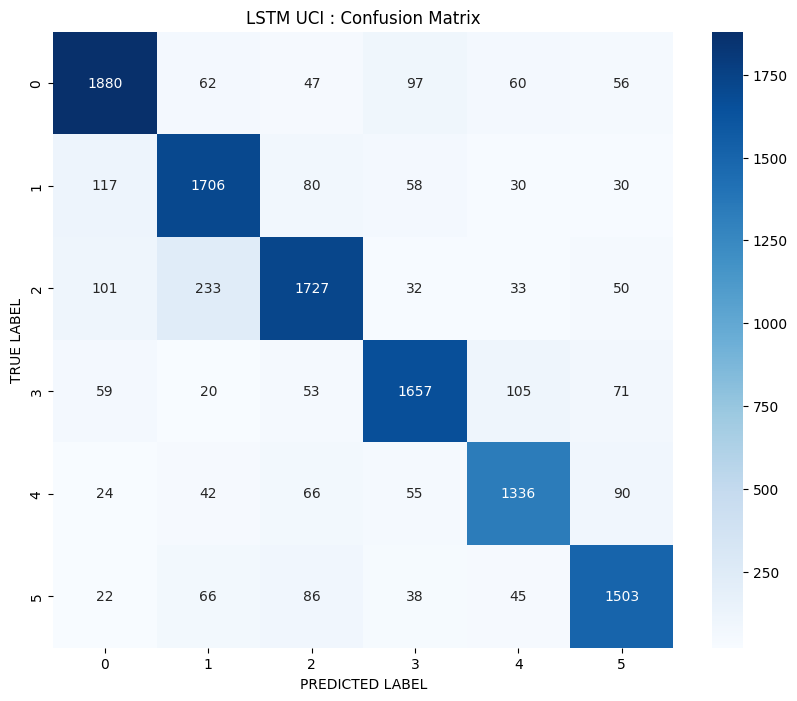

.....................................................!
Running for Traditional CNN.....................>>>>>
.....................................................!
Epoch 1/10
1652/1652 [==============================] - 12s 7ms/step - loss: 0.7123 - accuracy: 0.8169 - val_loss: 0.6619 - val_accuracy: 0.8297
Epoch 2/10
1652/1652 [==============================] - 11s 7ms/step - loss: 0.5965 - accuracy: 0.8432 - val_loss: 0.6089 - val_accuracy: 0.8391
Epoch 3/10
1652/1652 [==============================] - 11s 7ms/step - loss: 0.5581 - accuracy: 0.8467 - val_loss: 0.6070 - val_accuracy: 0.8374
Epoch 4/10
1652/1652 [==============================] - 11s 7ms/step - loss: 0.5283 - accuracy: 0.8490 - val_loss: 0.6149 - val_accuracy: 0.8397
Epoch 5/10
1652/1652 [==============================] - 11s 7ms/step - loss: 0.5060 - accuracy: 0.8488 - val_loss: 0.6177 - val_accuracy: 0.8380
Epoch 6/10
1652/1652 [==============================] - 11s 7ms/step - loss: 0.4852 - accuracy: 0.8500 - val_lo

'CNN: Classification Report.'

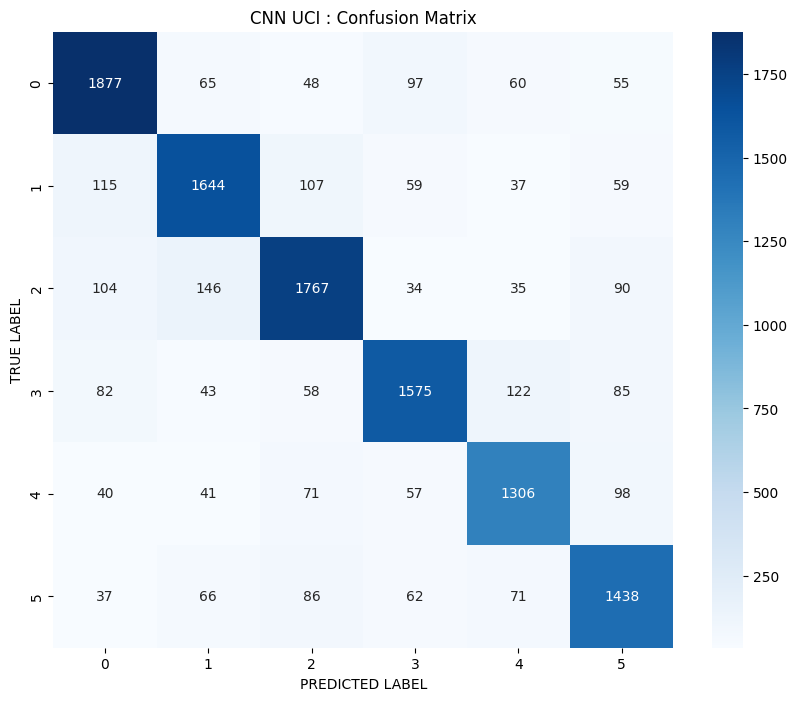

In [63]:
%run UCI_HAR_TraditionalMethod_DataAugmentation.ipynb

Data types in the dataset:
 User                                      int64
Activity                                 object
tBodyAcc-mean()-X                       float64
tBodyAcc-mean()-Y                       float64
tBodyAcc-mean()-Z                       float64
                                         ...   
angle(tBodyGyroMean,gravityMean)        float64
angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Length: 563, dtype: object 


Summary of missing values:
 User                                    0
Activity                                0
tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
                                       ..
angle(tBodyGyroMean,gravityMean)        0
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,

'RANDOM FOREST: Classification Report.'

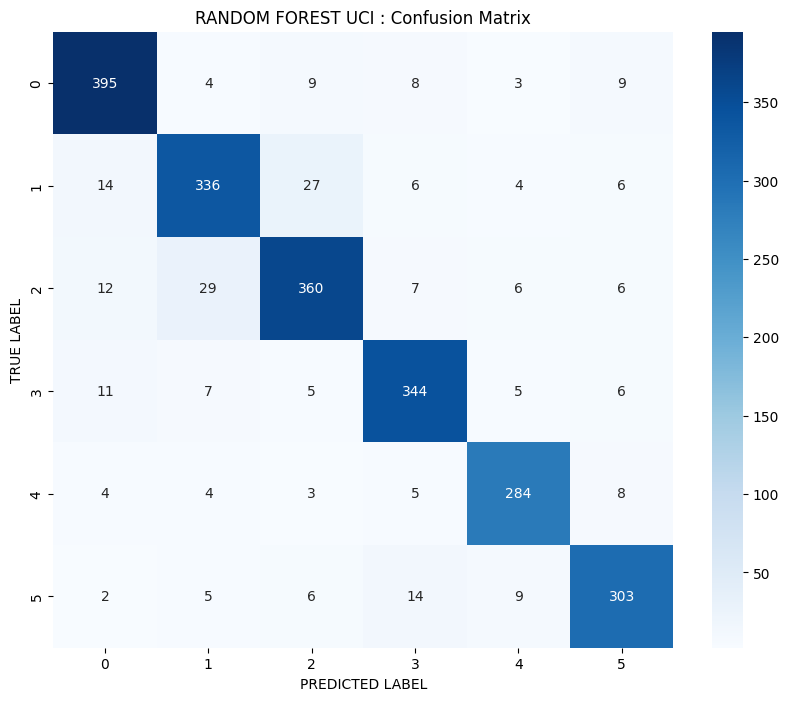

.....................................................!
Running for Advanced SVM.....................>>>>>
.....................................................!


'SVM: Classification Report.'

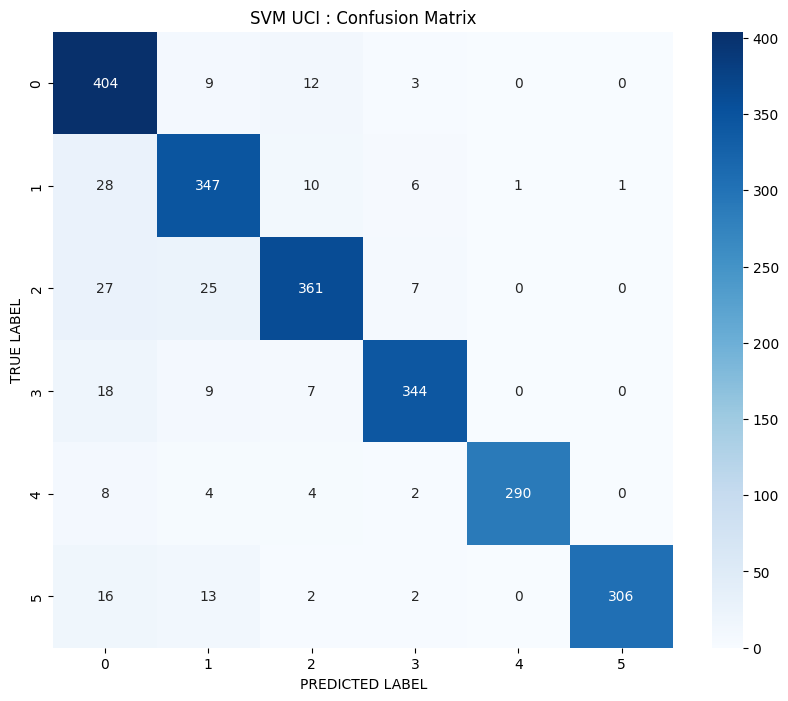

.....................................................!
Running for Advanced LSTM.....................>>>>>
.....................................................!
Epoch 1/10
114/114 [==============================] - 2s 6ms/step - loss: 0.6916 - accuracy: 0.7291 - val_loss: 0.3522 - val_accuracy: 0.8522
Epoch 2/10
114/114 [==============================] - 0s 3ms/step - loss: 0.3204 - accuracy: 0.8659 - val_loss: 0.3483 - val_accuracy: 0.8461
Epoch 3/10
114/114 [==============================] - 0s 3ms/step - loss: 0.2697 - accuracy: 0.8855 - val_loss: 0.2669 - val_accuracy: 0.8869
Epoch 4/10
114/114 [==============================] - 0s 3ms/step - loss: 0.2566 - accuracy: 0.8906 - val_loss: 0.2810 - val_accuracy: 0.8831
Epoch 5/10
114/114 [==============================] - 0s 3ms/step - loss: 0.2437 - accuracy: 0.8965 - val_loss: 0.2465 - val_accuracy: 0.8985
Epoch 6/10
114/114 [==============================] - 0s 3ms/step - loss: 0.2427 - accuracy: 0.8938 - val_loss: 0.2996 - val_acc

'LSTM: Classification Report.'

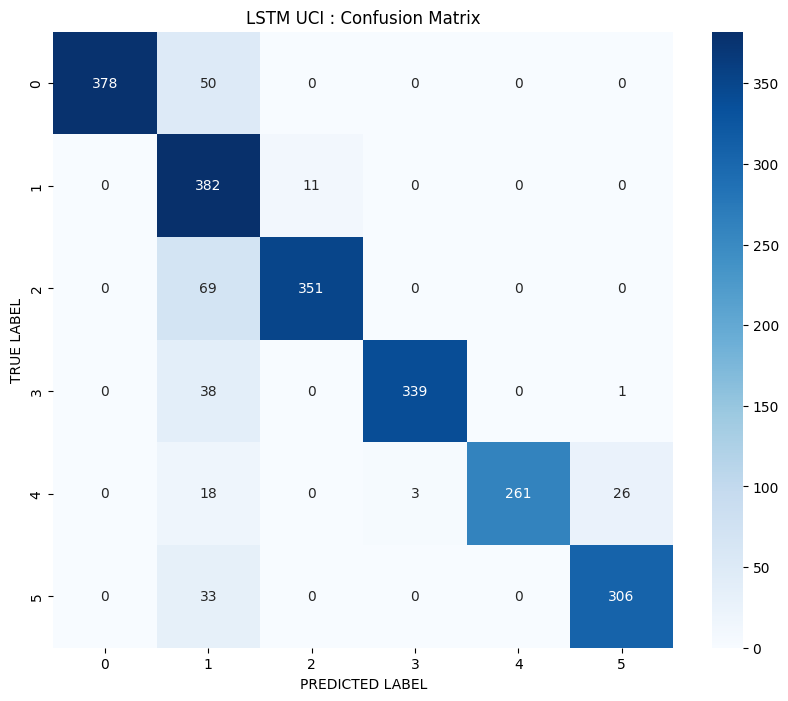

.....................................................!
Running for Advanced CNN.....................>>>>>
.....................................................!
Epoch 1/10
114/114 [==============================] - 4s 29ms/step - loss: 0.6339 - accuracy: 0.7449 - val_loss: 0.4026 - val_accuracy: 0.8687
Epoch 2/10
114/114 [==============================] - 3s 28ms/step - loss: 0.2966 - accuracy: 0.8917 - val_loss: 0.3098 - val_accuracy: 0.8792
Epoch 3/10
114/114 [==============================] - 3s 28ms/step - loss: 0.2576 - accuracy: 0.9033 - val_loss: 0.2819 - val_accuracy: 0.8941
Epoch 4/10
114/114 [==============================] - 3s 28ms/step - loss: 0.2319 - accuracy: 0.9094 - val_loss: 0.3742 - val_accuracy: 0.8533
Epoch 5/10
114/114 [==============================] - 3s 28ms/step - loss: 0.2307 - accuracy: 0.9084 - val_loss: 0.2425 - val_accuracy: 0.9046
Epoch 6/10
114/114 [==============================] - 3s 28ms/step - loss: 0.2079 - accuracy: 0.9172 - val_loss: 0.2607 - va

'CNN: Classification Report.'

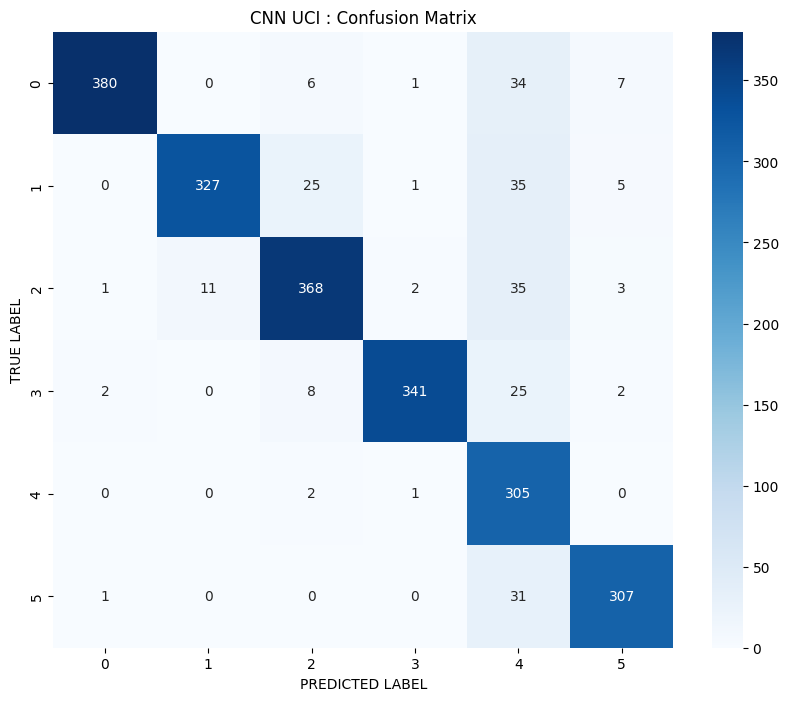

Epoch [10/100], Loss: 0.0
Epoch [20/100], Loss: 0.0
Epoch [30/100], Loss: 0.0
Epoch [40/100], Loss: 0.0
Epoch [50/100], Loss: 0.0
Epoch [60/100], Loss: 0.0
Epoch [70/100], Loss: 0.0
Epoch [80/100], Loss: 0.0
Epoch [90/100], Loss: 0.0
Epoch [100/100], Loss: 0.0
Shape of X_train: (8239, 562)
Shape of X_val: (2060, 562)
..........................TRAINING CPC...........................!
.....................................................!
Running for Advanced RANDOM FOREST.....................>>>>>
.....................................................!


'RANDOM FOREST: Classification Report.'

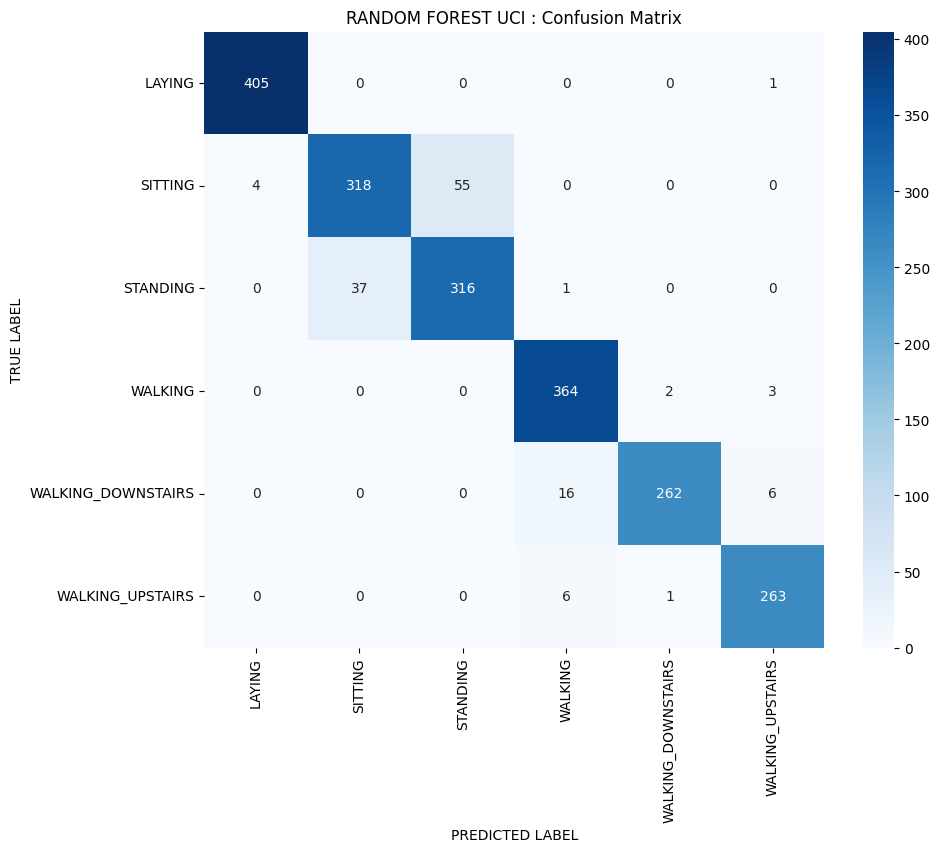

.....................................................!
Running for Advanced SVM.....................>>>>>
.....................................................!


'SVM: Classification Report.'

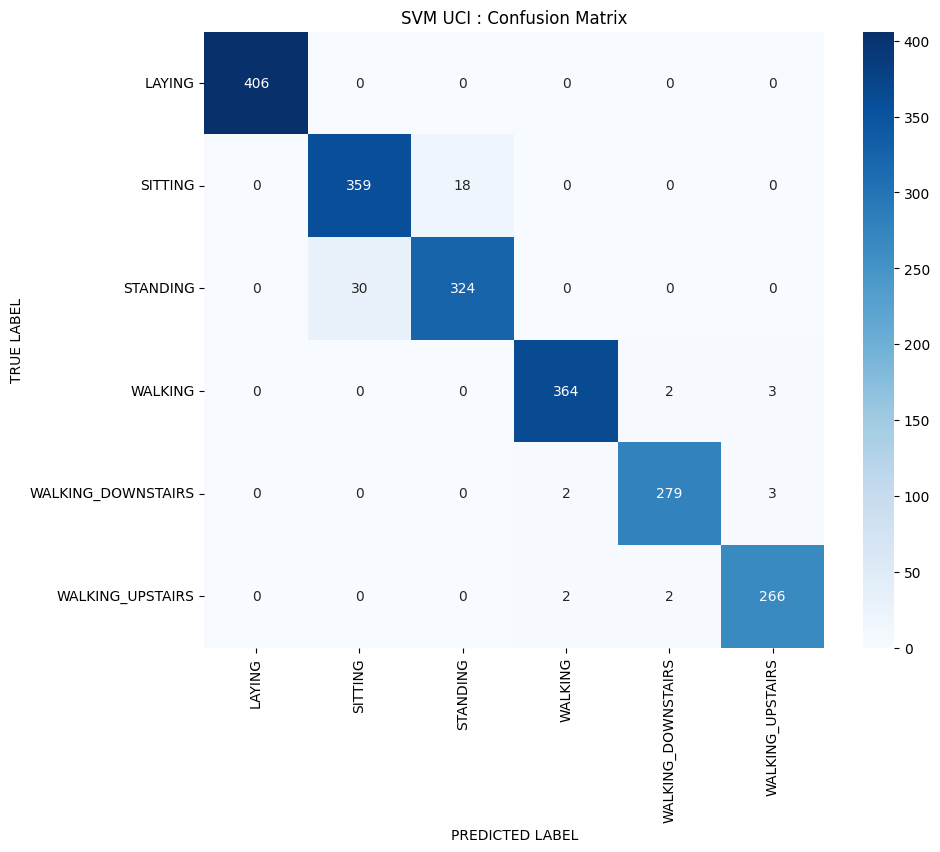

.....................................................!
Running for Advanced LSTM.....................>>>>>
.....................................................!
Epoch 1/10
103/103 [==============================] - 2s 6ms/step - loss: 0.4825 - accuracy: 0.8346 - val_loss: 0.1760 - val_accuracy: 0.9314
Epoch 2/10
103/103 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9528 - val_loss: 0.1346 - val_accuracy: 0.9454
Epoch 3/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0825 - accuracy: 0.9671 - val_loss: 0.1285 - val_accuracy: 0.9484
Epoch 4/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0560 - accuracy: 0.9803 - val_loss: 0.1092 - val_accuracy: 0.9612
Epoch 5/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0457 - accuracy: 0.9835 - val_loss: 0.0954 - val_accuracy: 0.9636
Epoch 6/10
103/103 [==============================] - 0s 3ms/step - loss: 0.0356 - accuracy: 0.9882 - val_loss: 0.1210 - val_acc

'LSTM: Classification Report.'

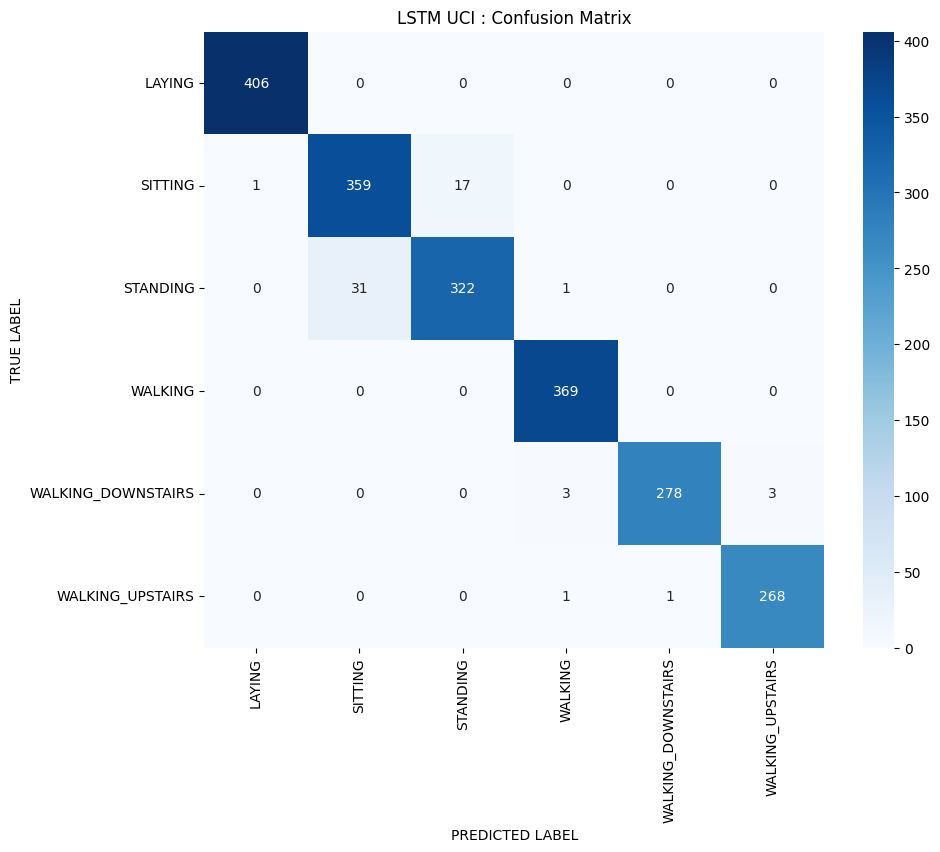

.....................................................!
Running for Advanced CNN.....................>>>>>
.....................................................!
Epoch 1/10
103/103 [==============================] - 3s 29ms/step - loss: 0.4994 - accuracy: 0.8125 - val_loss: 0.2543 - val_accuracy: 0.8962
Epoch 2/10
103/103 [==============================] - 3s 28ms/step - loss: 0.1787 - accuracy: 0.9323 - val_loss: 0.1954 - val_accuracy: 0.9278
Epoch 3/10
103/103 [==============================] - 3s 28ms/step - loss: 0.1203 - accuracy: 0.9560 - val_loss: 0.1388 - val_accuracy: 0.9502
Epoch 4/10
103/103 [==============================] - 3s 28ms/step - loss: 0.0814 - accuracy: 0.9731 - val_loss: 0.1275 - val_accuracy: 0.9508
Epoch 5/10
103/103 [==============================] - 3s 27ms/step - loss: 0.0860 - accuracy: 0.9689 - val_loss: 0.1134 - val_accuracy: 0.9630
Epoch 6/10
103/103 [==============================] - 3s 28ms/step - loss: 0.0500 - accuracy: 0.9816 - val_loss: 0.1112 - va

'CNN: Classification Report.'

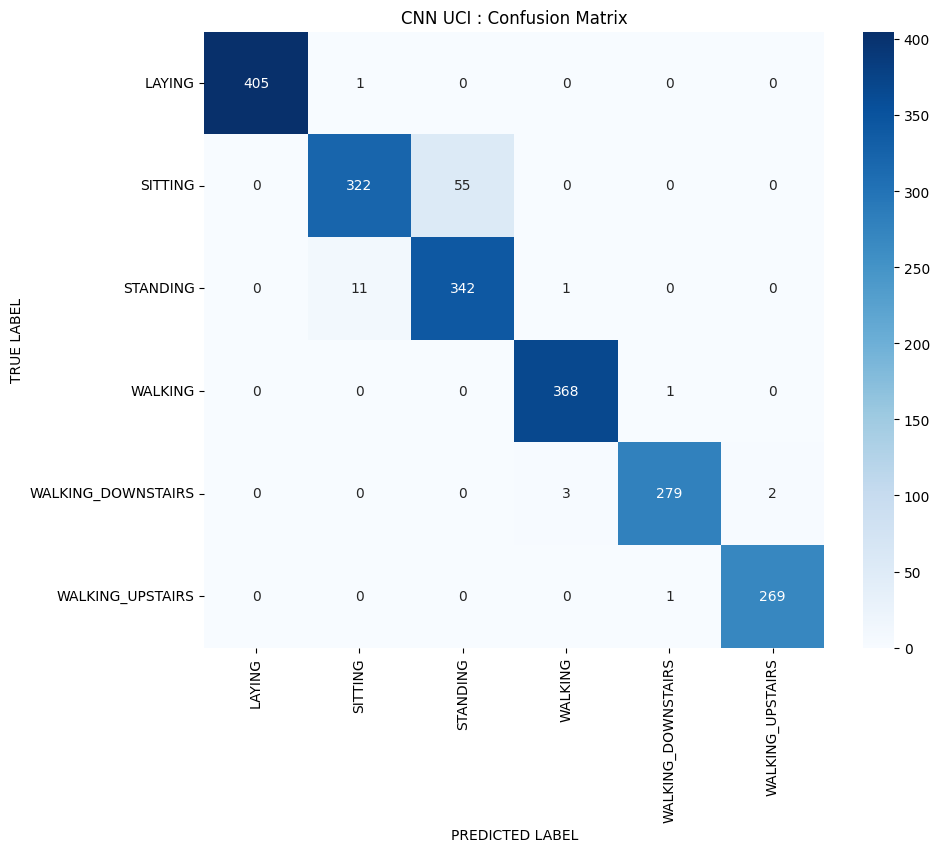

In [64]:
%run UCI_HAR_AdvancedMethods_DataAugmentation.ipynb